Here all the regression and visualitation are runned on single notebook to represent machine learning 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('NVDA.csv')
dataset = dataset.interpolate()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17880\3084596159.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dataset = dataset.interpolate()


In [3]:
X = dataset[['Open']]  # Features: Only Open
Y = dataset['Close']  # Target: Close

In [47]:
def encode_data(X, Y):

    X = pd.DataFrame(X)  # Ensure X is a DataFrame
    Y = pd.Series(Y) if isinstance(Y, pd.Series) else pd.Series(Y) # Ensure Y is a Series


    categorical_cols_X = X.select_dtypes(include='object').columns.tolist()

    # 1. Label Encode and then One-Hot Encode X
    if categorical_cols_X:
        X_encoded = X.copy()  # Create a copy to avoid modifying the original DataFrame
        for col in categorical_cols_X:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col])

        ct_X = ColumnTransformer([('encoder', OneHotEncoder(categories='auto', drop=None, handle_unknown='ignore'), categorical_cols_X)], remainder='passthrough')
        X_encoded = ct_X.fit_transform(X_encoded)
        X_encoded = X_encoded.toarray()
    else:
      X_encoded = X.values if isinstance(X, pd.DataFrame) else X # Handle cases where X might already be a numpy array

    # 2. Encode Y (Label Encode and then One-Hot Encode if categorical)
    if Y.dtype == 'object':
        le_y = LabelEncoder()
        Y_encoded = le_y.fit_transform(Y)

        ct_y = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough') # handle_unknown added
        Y_encoded = ct_y.fit_transform(Y_encoded.reshape(-1, 1))
        Y_encoded = Y_encoded.toarray()
    else:
        Y_encoded = Y.values.reshape(-1, 1) if isinstance(Y, pd.Series) else Y.reshape(-1, 1) # Reshape even if already numpy


    return X_encoded, Y_encoded


In [49]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [48]:
#Identify numerical columns *before* one-hot encoding
numerical_cols_before_encoding = ['Open']  # Or however you identify your numerical columns

In [51]:
# Apply one-hot encoding to the training and testing sets *separately*
ct = ColumnTransformer([('encoder', OneHotEncoder(categories='auto', drop=None), categorical_cols)], remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [52]:
# Convert to DataFrame *after* one-hot encoding
X_train_df = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=ct.get_feature_names_out())

In [53]:
# Get numerical column indices *after* one-hot encoding
numerical_indices = []
for col in numerical_cols_before_encoding:
    try:
        index = X_train_df.columns.get_loc(col)
        numerical_indices.append(index)
    except KeyError:
        pass

In [54]:
# Scale numerical features
scaler_X = StandardScaler()

if numerical_indices:
    X_train[:, numerical_indices] = scaler_X.fit_transform(X_train[:, numerical_indices])
    X_test[:, numerical_indices] = scaler_X.transform(X_test[:, numerical_indices])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5246, 1)
X_test shape: (1312, 1)
y_train shape: (5246, 1)
y_test shape: (1312, 1)


Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
# Train the Simple Linear Regression model
regressor = LinearRegression()

# Check if y_train is 1D or 2D and fit accordingly.
if y_train.ndim == 1:
    regressor.fit(X_train, y_train)
else:
    regressor.fit(X_train, y_train.ravel()) # .ravel() to convert to 1D if needed.


In [56]:
# Make predictions on the test set
y_pred = regressor.predict(X_test)

In [57]:
# Evaluate the model (optional - you'll likely want to do more thorough evaluation)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


# If you need to add the predicted values to your test dataframe.
X_test_df['predicted_close'] = y_pred

print(X_test_df)

R-squared: 0.999033994262607
      remainder__x0  predicted_close
0          0.174000         0.184119
1          4.390500         4.395265
2          0.182000         0.192108
3          0.169250         0.179375
4          0.274250         0.284241
...             ...              ...
1307       0.195000         0.205092
1308       0.460500         0.470255
1309      40.186001        40.145317
1310       0.586000         0.595596
1311       4.942500         4.946564

[1312 rows x 2 columns]


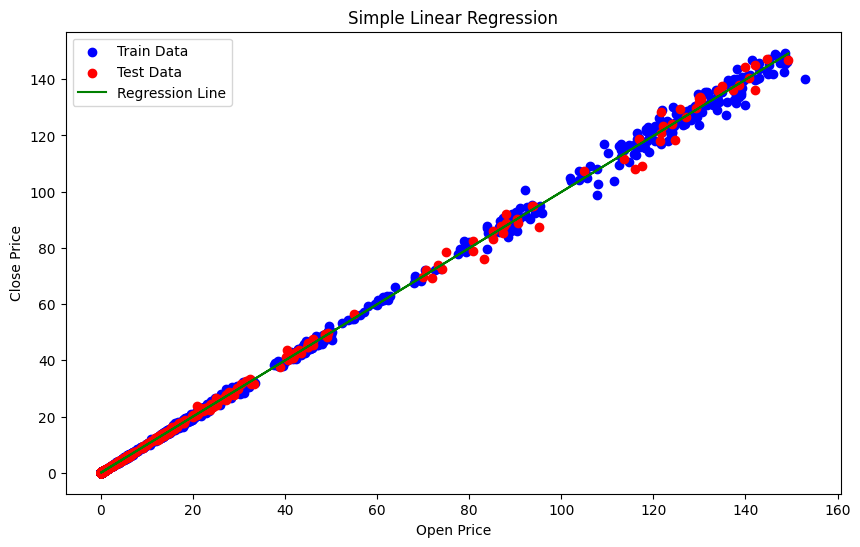

In [59]:
# Visualize the results (assuming only one feature after one-hot encoding)
import matplotlib.pyplot as plt

# Check the number of features after one-hot encoding
num_features = X_train.shape[1]

if num_features == 1:  # If only one feature, we can create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Train Data')
    plt.scatter(X_test, y_test, color='red', label='Test Data')
    plt.plot(X_test, y_pred, color='green', label='Regression Line')  # Plot the regression line
    plt.xlabel('Open Price')  # Update with your feature name
    plt.ylabel('Close Price')  # Update with your target variable name
    plt.title('Simple Linear Regression')
    plt.legend()
    plt.show()

Logistic Regression

In [60]:
# Create and train the Regression model
regressor = LinearRegression()  # Or another regression model like Ridge, Lasso, etc.
regressor.fit(X_train, y_train) # No need to use .ravel() here, as y_train should be a 1D array for regression targets.

LinearRegression()

In [61]:
# Make predictions on the test set
y_pred = regressor.predict(X_test)

In [62]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)



R-squared: 0.999033994262607
Mean Squared Error: 0.4748531473676111
Mean Absolute Error: 0.17352126673774823


K-Neighbors Regression 

In [63]:
from sklearn.neighbors import KNeighborsRegressor  # Import KNeighborsRegressor

# Create and train the K-NN Regressor model
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn_regressor.fit(X_train, y_train) # No need for .ravel() here.

KNeighborsRegressor()

In [64]:
# Make predictions on the test set
y_pred = knn_regressor.predict(X_test)

In [65]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.9989141301695502
Mean Squared Error: 0.5337739587470729
Mean Absolute Error: 0.1778964881830793


Using Support Vector Machine

In [66]:
from sklearn.svm import SVR  # Import SVR for regression


# Create and train the SVR model
svr_regressor = SVR(kernel='rbf')  # You can adjust the kernel and other hyperparameters
svr_regressor.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [67]:
# Make predictions on the test set
y_pred = svr_regressor.predict(X_test)

In [68]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.9961810229451126
Mean Squared Error: 1.877269672468084
Mean Absolute Error: 0.2961586742394134


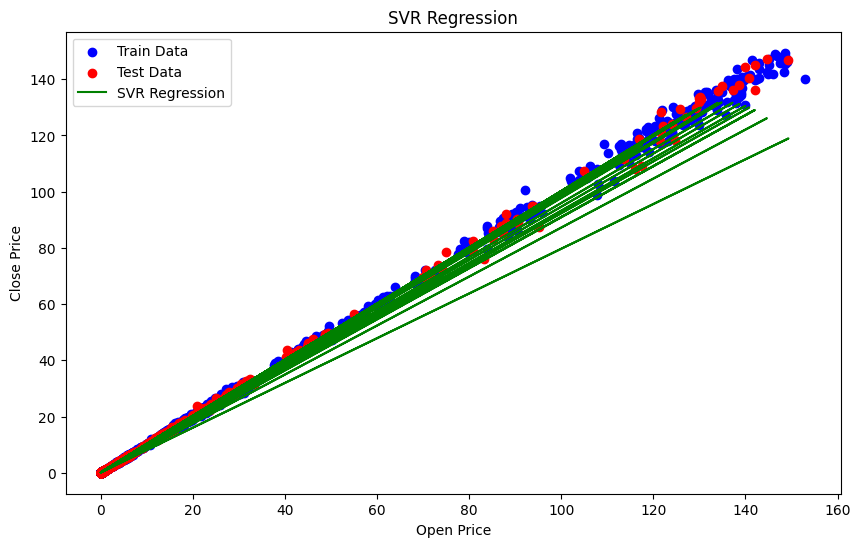

In [69]:

# Visualize the results (if you have only one or two features)
num_features = X_train.shape[1]

if num_features == 1:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Train Data')
    plt.scatter(X_test, y_test, color='red', label='Test Data')
    plt.plot(X_test, y_pred, color='green', label='SVR Regression')
    plt.xlabel('Open Price')  # Update with your feature name
    plt.ylabel('Close Price')  # Update with your target variable name
    plt.title('SVR Regression')
    plt.legend()
    plt.show()

Using Decision Tree Regression

In [70]:
from sklearn.tree import DecisionTreeRegressor

# Create and train the Decision Tree Regressor model
tree_regressor = DecisionTreeRegressor(random_state=0)  # You can adjust hyperparameters here
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [71]:
# Make predictions on the test set
y_pred = tree_regressor.predict(X_test)

In [72]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.9986412146311755
Mean Squared Error: 0.6679292720607116
Mean Absolute Error: 0.21416963589917973


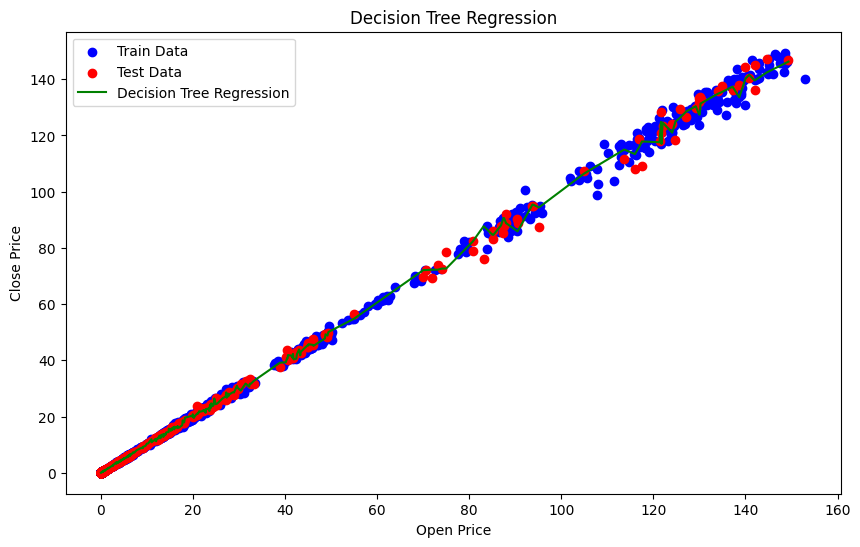

In [73]:
# Visualize the results (if you have only one or two features)
num_features = X_train.shape[1]

if num_features == 1:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Train Data')
    plt.scatter(X_test, y_test, color='red', label='Test Data')

    # Sort X_test for plotting the regression line smoothly
    X_test_sorted, y_pred_sorted = zip(*sorted(zip(X_test, y_pred))) # Sort X_test and y_pred together.

    plt.plot(X_test_sorted, y_pred_sorted, color='green', label='Decision Tree Regression')
    plt.xlabel('Open Price')  # Update with your feature name
    plt.ylabel('Close Price')  # Update with your target variable name
    plt.title('Decision Tree Regression')
    plt.legend()
    plt.show()



Using Random Forest Regression 

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)  # Adjust n_estimators and other hyperparameters
rf_regressor.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=0)

In [75]:
# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

In [76]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.998794772412121
Mean Squared Error: 0.5924458740205427
Mean Absolute Error: 0.19621422938063512


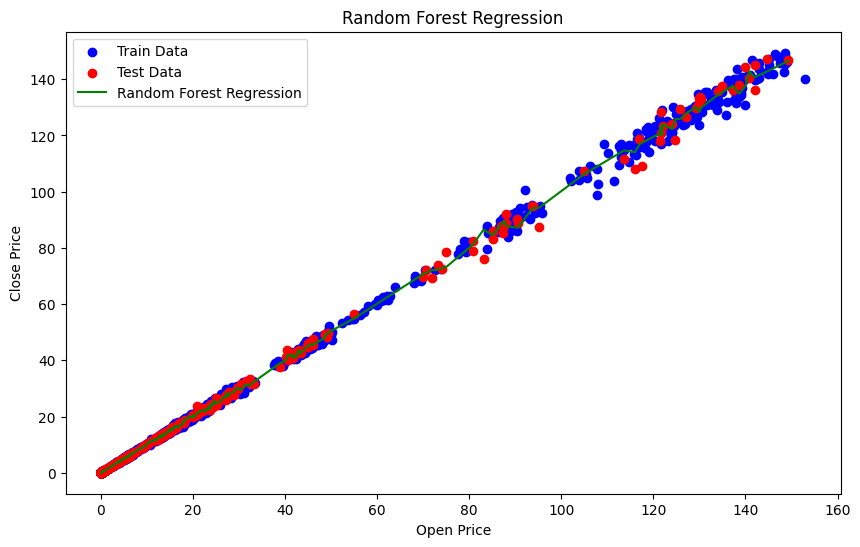

In [77]:
# Visualize the results (if you have only one or two features)
num_features = X_train.shape[1]

if num_features == 1:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Train Data')
    plt.scatter(X_test, y_test, color='red', label='Test Data')

    # Sort X_test for plotting the regression line smoothly
    X_test_sorted, y_pred_sorted = zip(*sorted(zip(X_test, y_pred)))

    plt.plot(X_test_sorted, y_pred_sorted, color='green', label='Random Forest Regression')
    plt.xlabel('Open Price')  # Update with your feature name
    plt.ylabel('Close Price')  # Update with your target variable name
    plt.title('Random Forest Regression')
    plt.legend()
    plt.show()
